# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## The tasks involved are the following three Parts:
### Part 0. Get to know the data
### Part 1. Customer Segmentation Report
### Part 2. Supervised learning model

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline 

# unsupervised machine learning
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
pd.set_option("max_columns",None)

In [4]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(azdias.shape)
azdias.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [5]:
# Count NaNs in each column in azdias
df3 =pd.DataFrame(azdias.isnull().sum()/azdias.shape[0])
df3.head()

,0
LNR,0.000000
AGER_TYP,0.000000
AKT_DAT_KL,0.082470
ALTER_HH,0.082470
ALTER_KIND1,0.909048


In [6]:
# Screen the columns which have over 90% null cells.
azdias_null_cols = list(df3[df3[0]>0.9].index) 
print(len(azdias_null_cols),"\n",azdias_null_cols)

4 
 ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']


In [7]:
print(customers.shape)
customers.head()

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [8]:
# Count NaNs in each column in customers.
df4 =pd.DataFrame(customers.isnull().sum()/customers.shape[0])
df4.head()

,0
LNR,0.000000
AGER_TYP,0.000000
AKT_DAT_KL,0.243128
ALTER_HH,0.243128
ALTER_KIND1,0.938607


In [9]:
# Screen the columns which have over 90% null cells.
customers_null_cols = list(df4[df4[0]>0.9].index) 
print(len(customers_null_cols),"\n",customers_null_cols)

4 
 ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']


In [6]:
# Remove the null columns from the data
azdias_null_cols =['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']
for col in azdias_null_cols:
    del azdias[col]
    del customers[col]

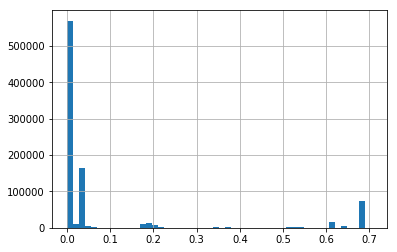

In [11]:
# Count NaNs in each rows in azdias
df1 =pd.DataFrame(azdias.isnull().sum(axis=1)/azdias.shape[1])
df1[0].hist(bins=50);

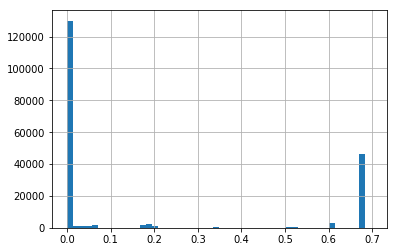

In [12]:
# Count NaNs in each rows in customers
df2 =pd.DataFrame(customers.isnull().sum(axis=1)/customers.shape[1])
df2[0].hist(bins=50);

In [13]:
# Choose some columns where there are no or few missing values
df4.sort_values(0,ascending=True).head(50)

,0
LNR,0.0
FINANZ_HAUSBAUER,0.0
FINANZ_ANLEGER,0.0
D19_WEIN_FEINKOST,0.0
D19_VOLLSORTIMENT,0.0
D19_VERSICHERUNGEN,0.0
D19_VERSI_ONLINE_DATUM,0.0
D19_VERSI_OFFLINE_DATUM,0.0
D19_VERSI_DATUM,0.0
D19_VERSI_ANZ_24,0.0


SEMIO_FAM
FINANZ_HAUSBAUER
FINANZ_ANLEGER
D19_TECHNIK
SEMIO_KAEM
SEMIO_SOZ


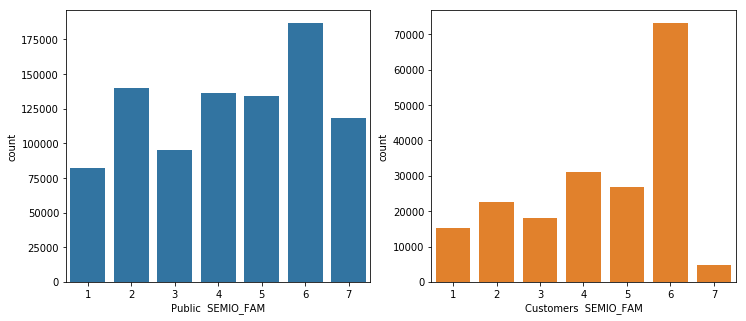

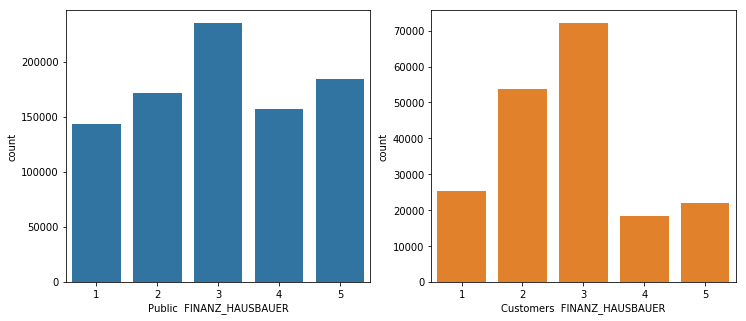

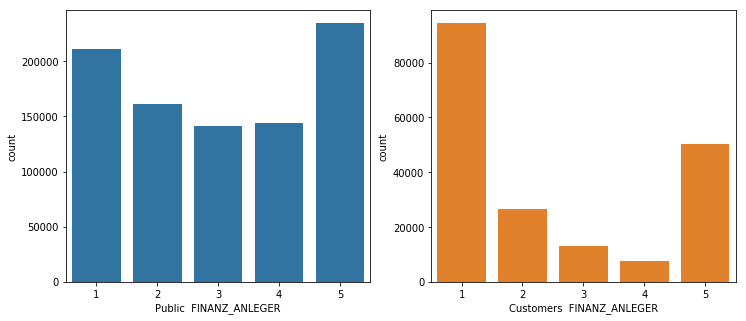

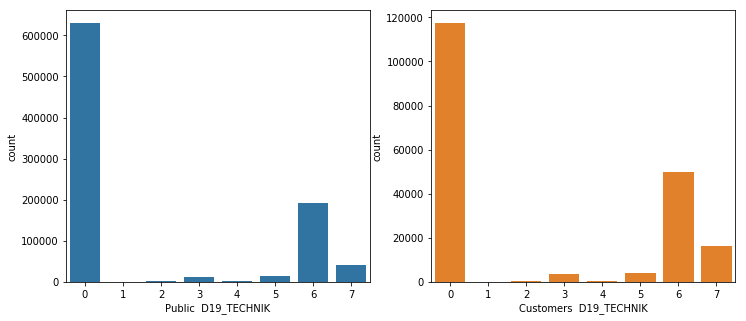

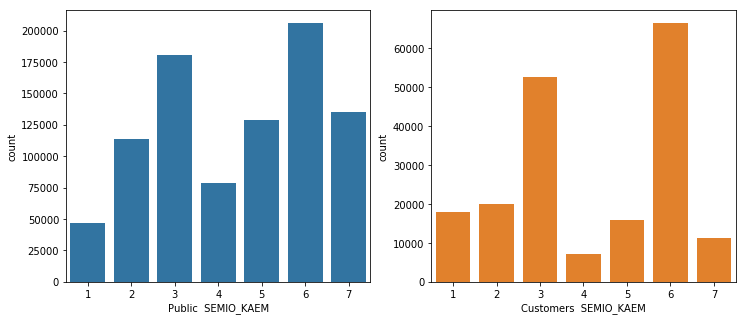

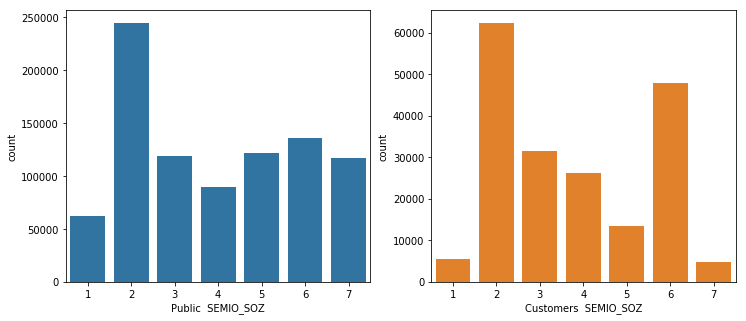

In [7]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols =["SEMIO_FAM","FINANZ_HAUSBAUER","FINANZ_ANLEGER","D19_TECHNIK","SEMIO_KAEM","SEMIO_SOZ"] #
for i in range(len(cols)):
    print(cols[i])
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1) #create subplots
    df_azdias = azdias[cols[i]]  #reshape images
    sns.countplot(df_azdias, color = sns.color_palette()[0]);
    plt.xlabel("Public  "+cols[i])
    
    plt.subplot(1,2,2)
    df_customers = customers[cols[i]]
    sns.countplot(df_customers, color = sns.color_palette()[1]);
    plt.xlabel("Customers  "+cols[i])
    plt.savefig(cols[i]+".png")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Step 1.1: Re-Encode Categorical Features 

In [8]:
# Assess all variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cols = list(azdias.columns)
binary_col = []
binary_value = []
multi_level_col = []
multi_level_value = []
for col in cols:
    if len(azdias[col].unique()) ==2:
        binary_col.append(col)
        binary_value.append(list(azdias[col].unique()))
    elif len(azdias[col].unique()) <=20:
        multi_level_col.append(col) 
        multi_level_value.append(list(azdias[col].unique()))
print(binary_col)
print(binary_value)
print(multi_level_col)
print(multi_level_value)

['GREEN_AVANTGARDE', 'ANREDE_KZ']
[[0, 1], [1, 2]]
['AGER_TYP', 'AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19

In [9]:
# It seems that binary_cols do not need to be Re-Encode.
print(binary_col)
print(binary_value)

['GREEN_AVANTGARDE', 'ANREDE_KZ']
[[0, 1], [1, 2]]


In [10]:
# It seems that multi_level_cols do not need to be Re-Encode.
print(multi_level_col[:5])
print(multi_level_value[:5])

['AGER_TYP', 'AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_TITEL', 'ARBEIT']
[[-1, 2, 3, 0, 1], [nan, 9.0, 1.0, 5.0, 8.0, 7.0, 6.0, 4.0, 3.0, 2.0], [nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 7.0, 11.0, 8.0], [nan, 0.0, 1.0, 2.0, 4.0, 3.0, 6.0], [nan, 3.0, 2.0, 4.0, 1.0, 5.0, 9.0]]


####  Step 1.2: Re-Encode String Values

In [11]:
# Get numerical values
df = pd.DataFrame(customers.describe())
num_cols = list(df.columns)

# Get string values
for col in customers.columns:
    if col not in num_cols:
        print(col,":",customers[col].isnull().sum(), "\n",list(customers[col].unique()),"\n\n")

CAMEO_DEU_2015 : 50428 
 ['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B', '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D', '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E', '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F', '4D', 'XX'] 


CAMEO_DEUG_2015 : 50428 
 [1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8', '9', '2', '4', '1', '7', '5', 'X'] 


CAMEO_INTL_2015 : 50428 
 [13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0, 51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0, '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35', '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'] 


D19_LETZTER_KAUF_BRANCHE : 47697 
 ['D19_UNBEKANNT', 'D19_BANKEN_GROSS', 'D19_NAHRUNGSERGAENZUNG', 'D19_SCHUHE', 'D19_BUCH_CD', 'D19_DROGERIEARTIKEL', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_VERSICHERUNGEN', 'D19_TELKO_MOBILE', 'D19_VOLLSORTIMENT', nan, 'D19_HAUS_DEKO', 'D19_E

PRODUCT_GROUP : 0 
 ['COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC'] 


CUSTOMER_GROUP : 0 
 ['MULTI_BUYER', 'SINGLE_BUYER'] 




#### "CUSTOMER_GROUP"  and "PRODUCT_GROUP" are labels.

In [12]:
del customers["D19_LETZTER_KAUF_BRANCHE"]
del azdias["D19_LETZTER_KAUF_BRANCHE"]
del customers["CAMEO_DEU_2015"]
del azdias["CAMEO_DEU_2015"]

In [13]:
# Investigate "OST_WEST_KZ"  and engineer a new variables.
def get_ost(x):
    try:
        if x =="W":
            return 1
        if x == "O":
            return 0
    except:
        return x
azdias["OST_WEST_KZ"] = azdias["OST_WEST_KZ"].apply(get_ost)

customers["OST_WEST_KZ"] = customers["OST_WEST_KZ"].apply(get_ost)

customers["OST_WEST_KZ"].value_counts()

1.0    130382
0.0     11343
Name: OST_WEST_KZ, dtype: int64

In [14]:
# Investigate "EINGEFUEGT_AM"  and engineer a new variables.
def get_year(x):
    try:
        return pd.to_datetime(x).year
    except:
        return x
azdias["EINGEFUEGT_AM"] = azdias["EINGEFUEGT_AM"].apply(get_year)

customers["EINGEFUEGT_AM"] = customers["EINGEFUEGT_AM"].apply(get_year)

customers["EINGEFUEGT_AM"].value_counts()

1992.0    108901
1995.0      5654
1996.0      5105
1993.0      3884
1997.0      3657
1994.0      2821
2005.0      2151
2003.0      1698
2004.0      1103
2000.0       957
2006.0       898
2007.0       649
2008.0       579
1998.0       546
2002.0       541
2009.0       486
2012.0       356
2011.0       343
2013.0       286
2010.0       284
2001.0       260
2014.0       224
2015.0       166
1999.0       166
2016.0        10
Name: EINGEFUEGT_AM, dtype: int64

In [15]:
def get_value(x):
    try:
        return x-1992
    except:
        return x
azdias["EINGEFUEGT_AM"] = azdias["EINGEFUEGT_AM"].apply(get_value)
customers["EINGEFUEGT_AM"] = customers["EINGEFUEGT_AM"].apply(get_value)
customers["EINGEFUEGT_AM"].value_counts()

0.0     108901
3.0       5654
4.0       5105
1.0       3884
5.0       3657
2.0       2821
13.0      2151
11.0      1698
12.0      1103
8.0        957
14.0       898
15.0       649
16.0       579
6.0        546
10.0       541
17.0       486
20.0       356
19.0       343
21.0       286
18.0       284
9.0        260
22.0       224
23.0       166
7.0        166
24.0        10
Name: EINGEFUEGT_AM, dtype: int64

In [17]:
# Investigate "CAMEO_DEUG_2015"  and "CAMEO_INTL_2015" and engineer two new variables.

def get_deug(x):
    try:
        if x =="X":
            return 10
        return int(x)
    except:
        return x
def get_intl(x):
    try:
        if x =="XX":
            return 10
        return int(x)/10
    except:
        return x
azdias["CAMEO_DEUG_2015"] = azdias["CAMEO_DEUG_2015"].apply(get_deug)
azdias["CAMEO_INTL_2015"] =azdias["CAMEO_INTL_2015"].apply(get_intl)

customers["CAMEO_DEUG_2015"] = customers["CAMEO_DEUG_2015"].apply(get_deug)
customers["CAMEO_INTL_2015"] =customers["CAMEO_INTL_2015"].apply(get_intl)

#### Step 1.3 Feature Transformation 

In [18]:
# Get numerical values
df = pd.DataFrame(customers.describe())
num_cols = list(df.columns)

for col in customers.columns:
    if col not in num_cols:
        print(col,":",customers[col].isnull().sum(), "\n",list(customers[col].unique()),"\n\n")

PRODUCT_GROUP : 0 
 ['COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC'] 


CUSTOMER_GROUP : 0 
 ['MULTI_BUYER', 'SINGLE_BUYER'] 




In [20]:
sample_customers = customers.copy()
del sample_customers["CUSTOMER_GROUP"]
del sample_customers["PRODUCT_GROUP"]
del sample_customers["LNR"]

### As there are many categorical features, we used most frequents values to fill the NaNs.

In [23]:
imputer =Imputer(missing_values="NaN", strategy="most_frequent",axis=0, verbose=0,copy=True)
clean_customers= imputer.fit_transform(sample_customers)

In [24]:
X = StandardScaler().fit_transform(clean_customers)

#### Step 1.4 Perform Dimensionality Reduction 

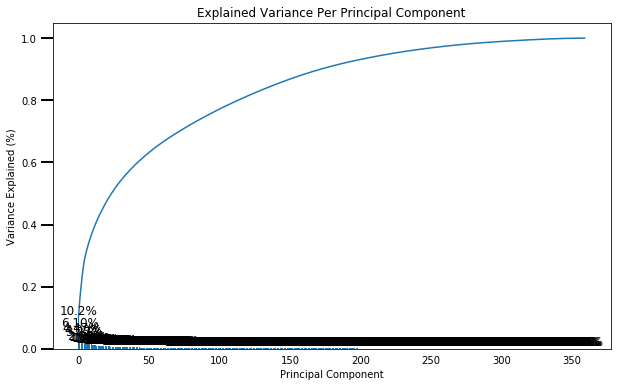

In [30]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(X)

# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.savefig("PCA.png")
scree_plot(pca)

### After 10% of the variability, there is a pretty strong flat-line of the amount of variance explained by each component. For this reason, I wouldn't go beyond ~30 components. I think it is fair to say the first 2-3 components are likely to hold information that we can dive into about the relationships (and latent features) in the original data.

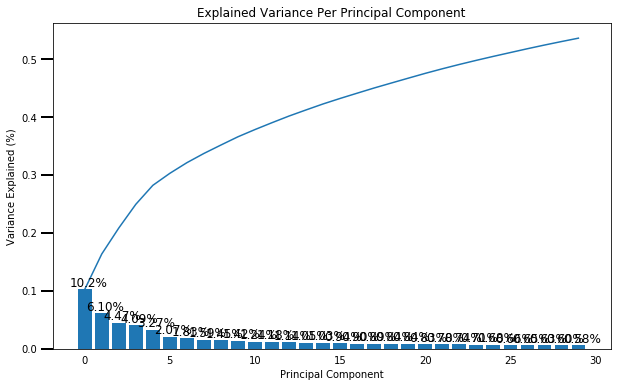

In [31]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(30)
X_pca = pca.fit_transform(X)
scree_plot(pca)

#### Discussion : Interpret Principal Components 

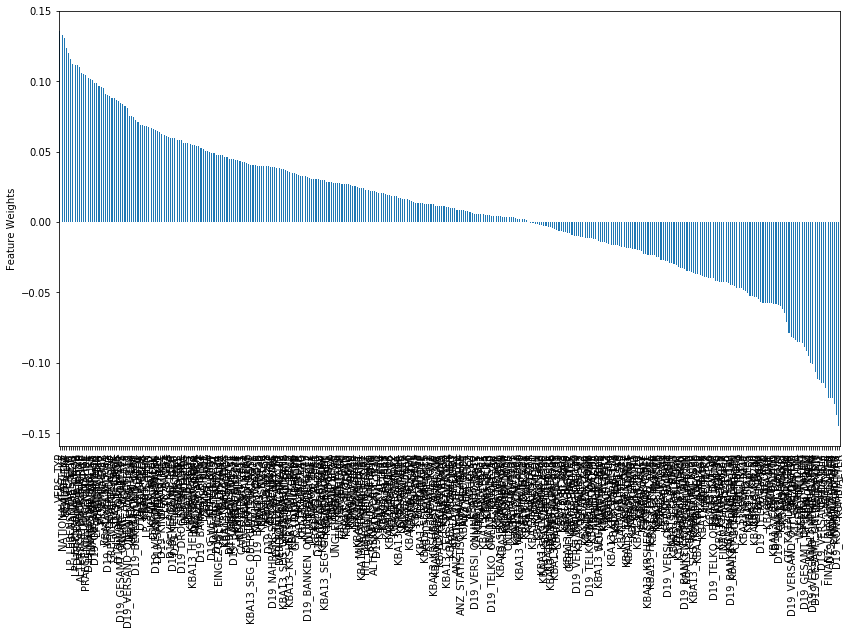

In [27]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca = PCA(30)
X_pca = pca.fit_transform(X)

def pca_component(full_dataset, pca,j):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.columns)
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Plot
    fig, ax = plt.subplots(figsize = (14,8))
    component =components.iloc[j-1,:].sort_values(ascending=False)
    component.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    #print(component)
    
    return components, variance_ratios
components, variance_ratios = pca_component(sample_customers, pca,1)

In [28]:
components.head(3)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA

In [29]:
for i in range(3):
    component = components.iloc[i,:].sort_values(ascending=False)
    print("PCA components ",i+1, "Top5 feature",component.index.tolist()[:5], "\n","Bottom5 Feature",component.index.tolist()[-5:],"\n\n")

PCA components  1 Top5 feature ['VERS_TYP', 'NATIONALITAET_KZ', 'HEALTH_TYP', 'SEMIO_VERT', 'ALTER_HH'] 
 Bottom5 Feature ['D19_GESAMT_DATUM', 'FINANZ_SPARER', 'FINANZ_ANLEGER', 'D19_KONSUMTYP_MAX', 'KOMBIALTER'] 


PCA components  2 Top5 feature ['KBA13_ANTG3', 'PLZ8_ANTG3', 'ORTSGR_KLS9', 'KBA13_BAUMAX', 'KBA13_ANTG4'] 
 Bottom5 Feature ['KBA13_HALTER_50', 'KBA13_HALTER_55', 'MOBI_REGIO', 'KBA13_AUTOQUOTE', 'KBA13_ALTERHALTER_60'] 


PCA components  3 Top5 feature ['KBA13_KMH_211', 'KBA13_KMH_250', 'KBA05_MOTOR', 'KBA13_KW_121', 'KBA13_HERST_BMW_BENZ'] 
 Bottom5 Feature ['KBA13_SEG_KLEINWAGEN', 'CAMEO_DEUG_2015', 'HH_EINKOMMEN_SCORE', 'KBA13_KMH_180', 'KBA13_KW_0_60'] 




### Discussion

#### 1 First Component: Mainly about health and finanz risk.
- VERS_TYP :insurance typology
- NATIONALITAET_KZ:nationaltity (scored by prename analysis)
- HEALTH_TYP: health typology
- ALTER_HH:main age within the household
- SEMIO_VERT:affinity indicating in what way the person is dreamily

#### 2 Second Component: Mainly about family houses.
- PLZ8_ANTG3: number of 6-10 family houses in the PLZ8
- ORTSGR_KLS9: classified number of inhabitants


#### 3 Third Component: Mainly about cars
- KBA13_KMH_211: share of cars with a greater max speed than 210 km/h within the PLZ8
- KBA13_KMH_250 : share of cars with max speed between 210 and 250 km/h within the PLZ8
- KBA05_MOTOR : most common engine size in the microcell
- KBA13_HERST_BMW_BENZ : share of BMW & Mercedes Benz within the PLZ8

### Step 1.5 Clustering

### Choose n clusters

In [36]:
clusters =[]
scores =[]
# Over a number of different cluster counts...
for k in range(2,15):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_pca)
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(X_pca))
    print(k,score)
    clusters.append(k)
    scores.append(score)

2 30847804.1559
3 27927661.7819
4 25268318.5508
5 23550767.3989
6 22313757.575
7 21743231.4838
8 21278616.3755
9 20854640.3933
10 20505702.5872
11 20185626.5871
12 19895815.5549
13 19635713.0536
14 19400869.6491


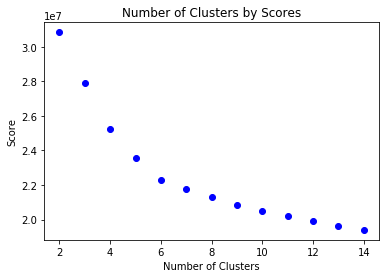

In [37]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters,scores,"bo");
plt.xlabel("Number of Clusters");
plt.ylabel("Score");
plt.title("Number of Clusters by Scores");
plt.savefig("kmeans_fig_1.png")

### After clusters increased to 6, there is a pretty strong flat-line of kmeans model scores. For this reason, I choose to split the customers into 6 subgroups. 

In [38]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=6, random_state=0).fit(X_pca)
labels =kmeans.labels_
customers["kmean_label"]=labels

In [39]:
from collections import Counter
Counter(labels)

Counter({5: 48448, 0: 28151, 4: 37660, 1: 29652, 2: 46808, 3: 933})

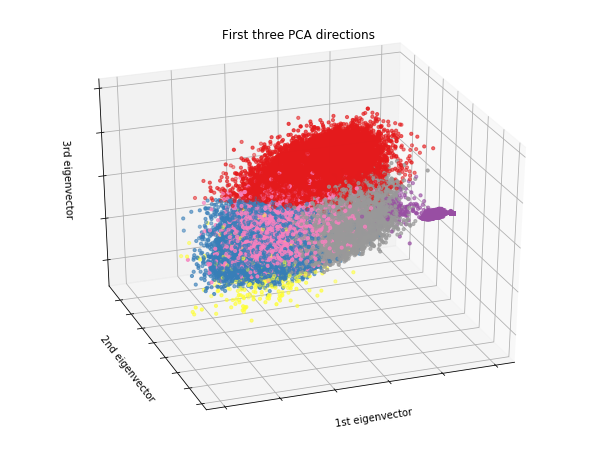

In [40]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels,
           cmap=plt.cm.Set1, s=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);
plt.savefig("PCA_kmeans.png")

In [47]:
print(customers[customers["kmean_label"]==0].shape[0])
customers[customers["kmean_label"]==0].loc[:,["PRODUCT_GROUP","CUSTOMER_GROUP","kmean_label"]].head(10)

28151


,PRODUCT_GROUP,CUSTOMER_GROUP,kmean_label
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
8,COSMETIC,MULTI_BUYER,0
14,COSMETIC_AND_FOOD,MULTI_BUYER,0
18,COSMETIC,SINGLE_BUYER,0
21,FOOD,SINGLE_BUYER,0
23,COSMETIC,SINGLE_BUYER,0
28,COSMETIC,MULTI_BUYER,0
29,FOOD,SINGLE_BUYER,0
32,FOOD,SINGLE_BUYER,0
81,COSMETIC_AND_FOOD,MULTI_BUYER,0


In [48]:
print(customers[customers["kmean_label"]==1].shape[0])
customers[customers["kmean_label"]==1].loc[:,["PRODUCT_GROUP","CUSTOMER_GROUP","kmean_label"]].head(10)

29652


,PRODUCT_GROUP,CUSTOMER_GROUP,kmean_label
5,COSMETIC_AND_FOOD,MULTI_BUYER,1
7,FOOD,SINGLE_BUYER,1
9,COSMETIC,MULTI_BUYER,1
15,COSMETIC_AND_FOOD,MULTI_BUYER,1
27,COSMETIC,SINGLE_BUYER,1
35,COSMETIC_AND_FOOD,MULTI_BUYER,1
45,COSMETIC_AND_FOOD,MULTI_BUYER,1
66,FOOD,SINGLE_BUYER,1
79,COSMETIC_AND_FOOD,MULTI_BUYER,1
99,COSMETIC_AND_FOOD,MULTI_BUYER,1


In [49]:
print(customers[customers["kmean_label"]==2].shape[0])
customers[customers["kmean_label"]==2].loc[:,["PRODUCT_GROUP","CUSTOMER_GROUP","kmean_label"]].head(10)

46808


,PRODUCT_GROUP,CUSTOMER_GROUP,kmean_label
36,FOOD,MULTI_BUYER,2
37,FOOD,SINGLE_BUYER,2
38,COSMETIC,SINGLE_BUYER,2
39,COSMETIC,SINGLE_BUYER,2
40,COSMETIC,SINGLE_BUYER,2
43,COSMETIC_AND_FOOD,MULTI_BUYER,2
44,FOOD,SINGLE_BUYER,2
46,COSMETIC,SINGLE_BUYER,2
51,FOOD,SINGLE_BUYER,2
53,FOOD,SINGLE_BUYER,2


In [50]:
print(customers[customers["kmean_label"]==3].shape[0])
customers[customers["kmean_label"]==3].loc[:,["PRODUCT_GROUP","CUSTOMER_GROUP","kmean_label"]].head(10)

933


,PRODUCT_GROUP,CUSTOMER_GROUP,kmean_label
244,COSMETIC_AND_FOOD,MULTI_BUYER,3
398,COSMETIC_AND_FOOD,MULTI_BUYER,3
443,FOOD,SINGLE_BUYER,3
510,FOOD,MULTI_BUYER,3
1043,COSMETIC_AND_FOOD,MULTI_BUYER,3
1200,COSMETIC,MULTI_BUYER,3
1352,COSMETIC_AND_FOOD,MULTI_BUYER,3
1446,COSMETIC,SINGLE_BUYER,3
1485,COSMETIC_AND_FOOD,MULTI_BUYER,3
1651,FOOD,SINGLE_BUYER,3


In [51]:
print(customers[customers["kmean_label"]==4].shape[0])
customers[customers["kmean_label"]==4].loc[:,["PRODUCT_GROUP","CUSTOMER_GROUP","kmean_label"]].head(10)

37660


,PRODUCT_GROUP,CUSTOMER_GROUP,kmean_label
4,FOOD,MULTI_BUYER,4
10,COSMETIC,MULTI_BUYER,4
11,FOOD,SINGLE_BUYER,4
12,FOOD,SINGLE_BUYER,4
13,FOOD,SINGLE_BUYER,4
16,COSMETIC,SINGLE_BUYER,4
17,COSMETIC,MULTI_BUYER,4
20,FOOD,SINGLE_BUYER,4
25,COSMETIC_AND_FOOD,MULTI_BUYER,4
30,COSMETIC_AND_FOOD,MULTI_BUYER,4


In [52]:
print(customers[customers["kmean_label"]==5].shape[0])
customers[customers["kmean_label"]==5].loc[:,["PRODUCT_GROUP","CUSTOMER_GROUP","kmean_label"]].head(10)

48448


,PRODUCT_GROUP,CUSTOMER_GROUP,kmean_label
0,COSMETIC_AND_FOOD,MULTI_BUYER,5
1,FOOD,SINGLE_BUYER,5
3,COSMETIC,MULTI_BUYER,5
6,COSMETIC_AND_FOOD,MULTI_BUYER,5
19,FOOD,SINGLE_BUYER,5
22,FOOD,SINGLE_BUYER,5
24,COSMETIC_AND_FOOD,MULTI_BUYER,5
26,COSMETIC,MULTI_BUYER,5
33,FOOD,SINGLE_BUYER,5
42,FOOD,SINGLE_BUYER,5


### Discussion

### Furthermore, we found that people in cluster 2 are more likely be single-buyer, while people in cluster 3 are more likely be multi-buyer; People in cluster 1 are more lilkely to buy cosmetics, while people in cluster 2,4,and 5 are not.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [111]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [112]:
# how many postive samples are in the data set?
mailout_train["RESPONSE"].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [113]:
mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [114]:
# Investigate "OST_WEST_KZ"  and engineer a new variables.
def get_ost(x):
    try:
        if x =="W":
            return 1
        if x == "O":
            return 0
    except:
        return x
    
# Investigate "EINGEFUEGT_AM"  and engineer a new variables.
def get_year(x):
    try:
        return pd.to_datetime(x).year
    except:
        return x
    
def get_value(x):
    try:
        return x-1992
    except:
        return x
    
# Investigate "CAMEO_DEUG_2015"  and "CAMEO_INTL_2015" and engineer two new variables.
def get_deug(x):
    try:
        if x =="X":
            return 10
        return int(x)
    except:
        return x
def get_intl(x):
    try:
        if x =="XX":
            return 10
        return int(x)/10
    except:
        return x

In [115]:
null_cols =['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']
def clean_data(df):
    for col in null_cols:
        del df[col]   # delete null cols
        
    # re-encoding string values in the df
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].apply(get_ost)  
    df["EINGEFUEGT_AM"] = df["EINGEFUEGT_AM"].apply(get_year)
    df["EINGEFUEGT_AM"] = df["EINGEFUEGT_AM"].apply(get_value)
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].apply(get_deug)
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].apply(get_intl)
    del df["D19_LETZTER_KAUF_BRANCHE"]
    del df["CAMEO_DEU_2015"]
    
    return df
mailout_train =clean_data(mailout_train)
#test_data =clean_data(test_data)

In [116]:
# Use 1/3 Postive samples and equal numbers of negative samples as test data.
df1 = mailout_train[mailout_train["RESPONSE"]==1]
df2 = mailout_train[mailout_train["RESPONSE"]==0]
test_idx_1 = random.sample(list(df1.index),int(df1.shape[0]*0.33))
test_idx_2 = random.sample(list(df2.index),int(df1.shape[0]*0.33))
test_data = mailout_train.iloc[test_idx_1+test_idx_2,:]

# Use 2/3 Postive samples and equal numbers of negative samples as train data.
idxs = list(mailout_train.index)
test_idx =test_idx_1+test_idx_2
for i in test_idx:
    idxs.remove(i)
train_df = mailout_train.iloc[idxs,:]

train_df1 = train_df[train_df["RESPONSE"]==1]
train_df2 = train_df[train_df["RESPONSE"]==0]
train_data =[]
for i in range(int(train_df2.shape[0]/train_df1.shape[0])):
    train_data.append(train_df1)
train_data.append(train_df2)

train_data = pd.concat(train_data)
print("Train data",train_data.shape)
print("Test data",test_data.shape)

Train data (84381, 361)
Test data (350, 361)


In [117]:
train_data = train_data.sort_index().reset_index(drop=True)
train_labels = train_data.RESPONSE.tolist()

test_data = test_data.sort_index().reset_index(drop=True)
test_labels = test_data.RESPONSE.tolist()

del train_data["LNR"]
del train_data["RESPONSE"]
    
del test_data["LNR"]
del test_data["RESPONSE"]

In [118]:
def get_stand_data(data):
    imputer =Imputer(missing_values="NaN", strategy="most_frequent",axis=0, verbose=0,copy=True)
    data= imputer.fit_transform(data)
    data_X = StandardScaler().fit_transform(data)
    return data_X

In [119]:
def get_stand_data(data):
    imputer =Imputer(missing_values="NaN", strategy="most_frequent",axis=0, verbose=0,copy=True)
    data= imputer.fit_transform(data)
    data_X = StandardScaler().fit_transform(data)
    return data_X
def get_pca(train,test):
    imputer =Imputer(missing_values="NaN", strategy="most_frequent",axis=0, verbose=0,copy=True)
    train= imputer.fit_transform(train)
    train_X = StandardScaler().fit_transform(train)
    
    test= imputer.transform(test)
    test_X = StandardScaler().fit_transform(test)
    
    pca = PCA(30)
    X_train_pca = pca.fit_transform(train_X)
    X_test_pca =pca.transform(test_X)
    return X_train_pca, X_test_pca
train = get_stand_data(train_data)
test = get_stand_data(test_data)

In [121]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train,test,train_labels,test_labels
clf = SGDClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


             precision    recall  f1-score   support

          0       0.61      0.54      0.57       175
          1       0.59      0.65      0.62       175

avg / total       0.60      0.60      0.60       350



In [ ]:
df =classification_report(y_test, y_pred)
df

In [ ]:
sns.heatmap(classification_report(y_test, y_pred))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [122]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [123]:
mailout_test =clean_data(mailout_test)
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT

In [124]:
IDs = mailout_test.LNR.tolist()
test_data = mailout_test.iloc[:,1:]
test_data = get_stand_data(test_data)

In [125]:
pred = clf.predict(test_data)
df =pd.DataFrame(IDs,columns =["LNR"])
df["RESPONSE"] = pd.DataFrame(pred)
df.head()

,LNR,RESPONSE
0,1754,1
1,1770,1
2,1465,0
3,1470,0
4,1478,1


In [126]:
df.to_csv("Kaggle_Competition_Prediction.csv")

## Conclusion
### PCA
- When there are many features, we can reduce the time and space complexity of the problem by reducing the dimension.
- By analyzing the principal components of the data, we can understand some meaningful relationships between features, and then  understand the data more deeply.
### KMeans
- When we don't know the number of clusters, we can determine the number of clusters through experiments by findout the inflection point of the decline of clustering score.
- PCA can be used to visualize the clustering of high-dimensional data and help us to judge the clustering quality.
### Supervised machine learning
- When the positive and negative samples are very unbalanced, we can use the up-sampling technology to increase the number of positive examples and optimize the performance of the model.